In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys
sys.path.append("..")

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from collections import OrderedDict
from src.config import cfg

In [41]:
# Set up place to download pretrained model from internet
import os
os.environ['TORCH_HOME'] = '../models/pretrained/'

In [34]:
from src.data.dataload import DataLoader
from src.data.datasplit import DataSplit
from src.data.dataload import FaceToBMIDataset

In [35]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Set this when run on laptop otherwise comment it out
train_on_gpu = False

CUDA is not available.  Training on CPU ...


In [36]:
processed_path = "../data/processed/"
print("Loading data ....")
train_loader = torch.load(processed_path+"train_loader.pt")
valid_loader = torch.load(processed_path+"val_loader.pt")
test_loader = torch.load(processed_path+"test_loader.pt")
print("Done!")

Loading data ....
Done!


In [37]:
model = models.resnet50(pretrained=True)
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [38]:
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ("output", nn.Linear(2048, 1))
]))

model.fc = fc
print(model.fc)

# move tensors to GPU if CUDA is available
if train_on_gpu:
  
    model.cuda()

Sequential(
  (output): Linear(in_features=2048, out_features=1, bias=True)
)


In [39]:
# Checking if trained model is empty, if it is not then reload it
import os
if len(os.listdir("../models/training/")) == 0:
    print("No current training model!")
else:
    # model.load_state_dict(torch.load('../models/training/on_training_model.pt')) #Using this when training with GPU
    model.load_state_dict(torch.load('../models/training/on_training_model.pt', map_location=torch.device('cpu')));

In [23]:
base_learning_rate = 1e-5
epochs = 1 #should be 500 change to 400000 if you are a rich kid!
weight_decay = 0.0005
gamma = 0.001
power = 0.75
criterion = nn.SmoothL1Loss()
if train_on_gpu:
    criterion.cuda()
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

In [24]:
#training model
for epoch in range(epochs):
    
    learning_rate = base_learning_rate*(1+gamma*epoch)**(-power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, _, _, bmi in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, bmi = images.cuda(), bmi.cuda()

        # Reset optimizer
        optimizer.zero_grad()

        #Training model
        predictions = model(images)

        #Calculate loss
        loss = criterion(predictions, bmi)
        
        #Backpropagation
        loss.backward()

        #Update weight
        optimizer.step()
    
        #Calculate running loss
        train_loss += loss.item()*images.size(0)

    ######################    
    # validate the model #
    ######################

    else:
        model.eval()   
        #Turn off the gradient descent, save memory and computations
        for images, _, _, bmi in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, bmi = images.cuda(), bmi.cuda()
                
            #Run model
            predictions = model(images)
            loss = criterion(predictions,bmi)
            valid_loss += loss.item()*images.size(0)
    
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(
            "Epoch: {}/{}..".format(epoch+1, epochs),
            "Training loss: {:.3f}".format(train_loss),
            "Validating loss: {:.3f}".format(valid_loss)
        )
         
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), '../models/trained/best_model.pt') # for testing
            valid_loss_min = valid_loss # for further training

Epoch: 1/1.. Training loss: 1.885 Validating loss: 1.929
Validation loss decreased (inf --> 1.929484).  Saving model ...


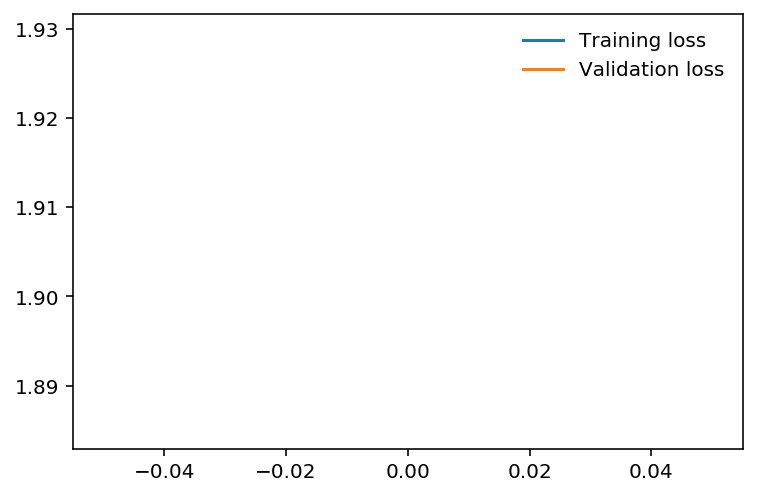

In [25]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False);

In [26]:
model.load_state_dict(torch.load('../models/trained/best_model.pt'));

In [27]:
#track test loss
test_loss = 0.0
model.eval()
test_criterion = nn.L1Loss()
for images, _, _, bmi in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, bmi = images.cuda(), bmi.cuda()
        test_criterion = test_criterion.cuda()
    
    #Run model
    predictions = model(images)
    loss = test_criterion(predictions,bmi)
    test_loss += loss.item()*images.size(0)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.3f}\n'.format(test_loss))

Test Loss: 0.515



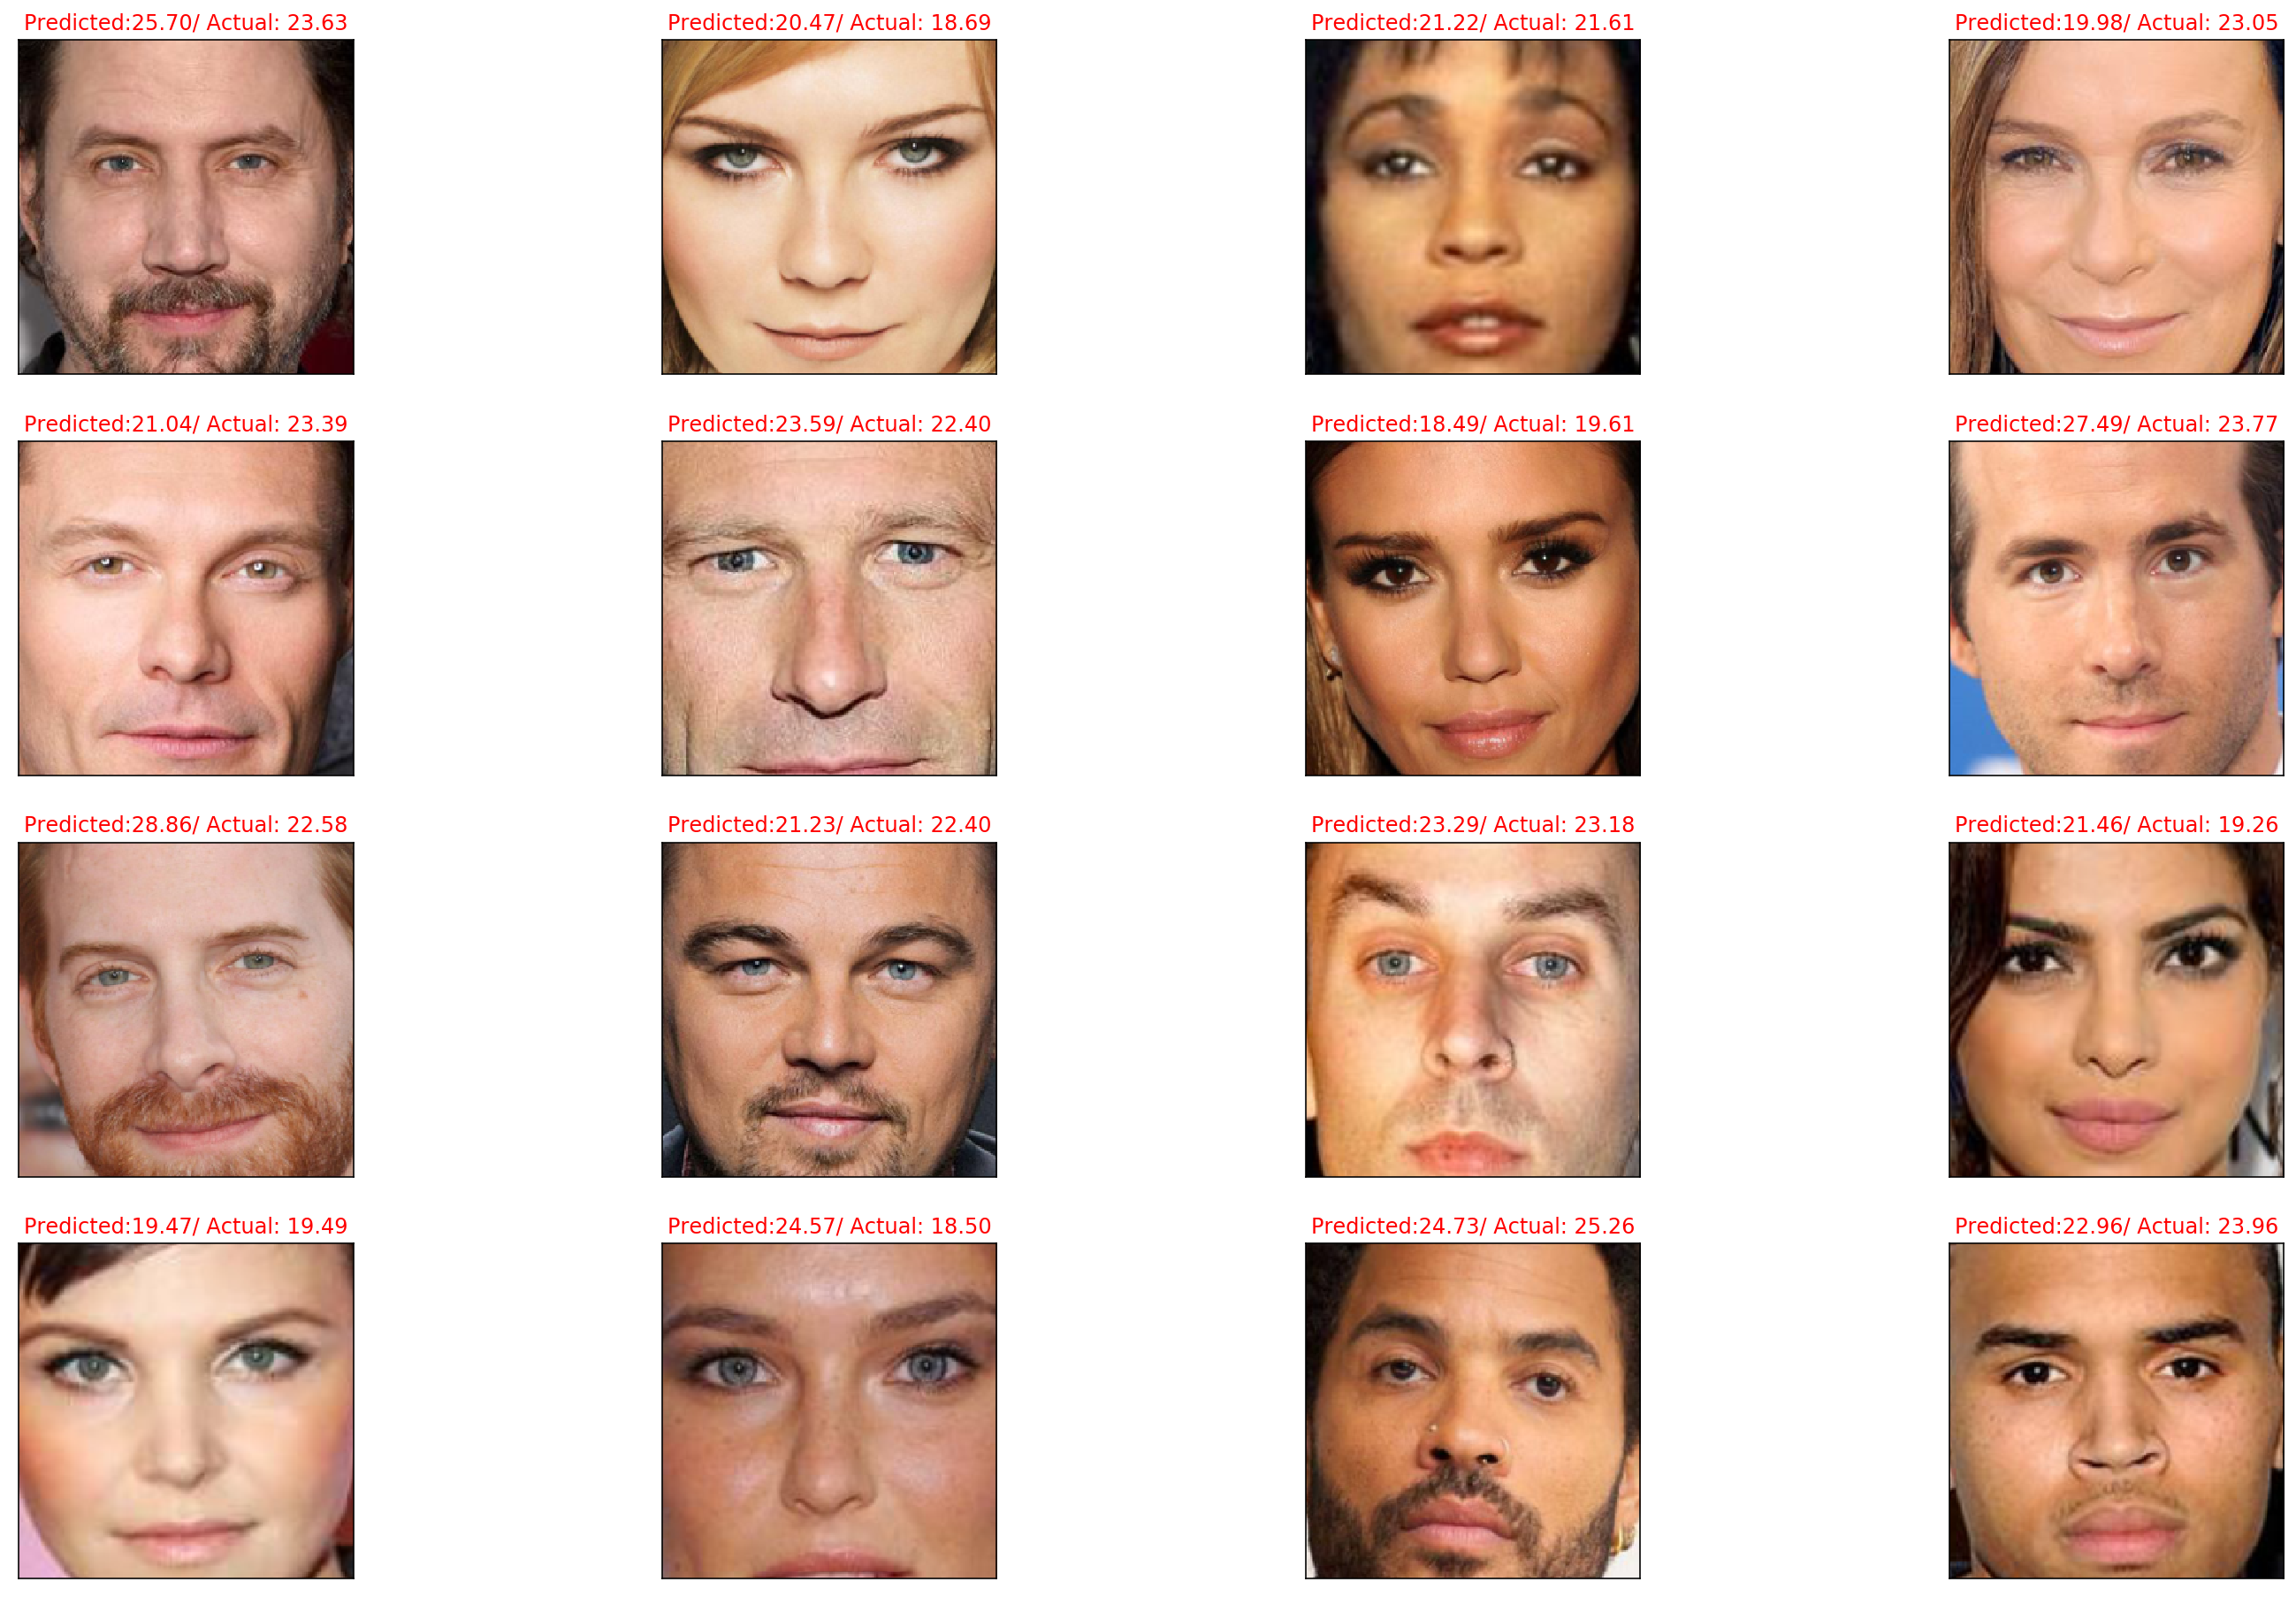

In [28]:
batch_size = 16
# obtain one batch of test images
images, height, weight, bmi = next(iter(test_loader))

# get sample predictions
predictions = model(images)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, batch_size))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx,:], (1,2,0)))
    ax.set_title(
        "Predicted:{:.2f}/ Actual: {:.2f}".format(predictions[idx,:].item(), bmi[idx,:].item()), 
                    color=("green" if predictions[idx,:].item() == bmi[idx,:].item() else "red"))